In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd 
import numpy as np

In [3]:
flights = pd.read_csv('../data/flights.csv')

flights.head()

,MONTH,DAY,WEEKDAY,AIRLINE,ORG_AIR,DEST_AIR,SCHED_DEP,DEP_DELAY,AIR_TIME,DIST,SCHED_ARR,ARR_DELAY,DIVERTED,CANCELLED
0,1,1,4,WN,LAX,SLC,1625,58.0,94.0,590,1905,65.0,0,0
1,1,1,4,UA,DEN,IAD,823,7.0,154.0,1452,1333,-13.0,0,0
2,1,1,4,MQ,DFW,VPS,1305,36.0,85.0,641,1453,35.0,0,0
3,1,1,4,AA,DFW,DCA,1555,7.0,126.0,1192,1935,-7.0,0,0
4,1,1,4,WN,LAX,MCI,1720,48.0,166.0,1363,2225,39.0,0,0


In [8]:
flights['DELAYED'] = flights['ARR_DELAY'].ge(15).astype(int)
cols = ['DIVERTED', 'CANCELLED', 'DELAYED']
flights['ON_TIME'] = 1 - flights[cols].any(axis=1)
cols.append('ON_TIME')
flights[cols].head()

,DIVERTED,CANCELLED,DELAYED,ON_TIME
0,0,0,1,0
1,0,0,0,1
2,0,0,1,0
3,0,0,0,1
4,0,0,1,0


In [9]:
status = flights[cols].sum()
status

DIVERTED       137
CANCELLED      881
DELAYED      11685
ON_TIME      45789
dtype: int64

In [10]:
type(status)

pandas.core.series.Series

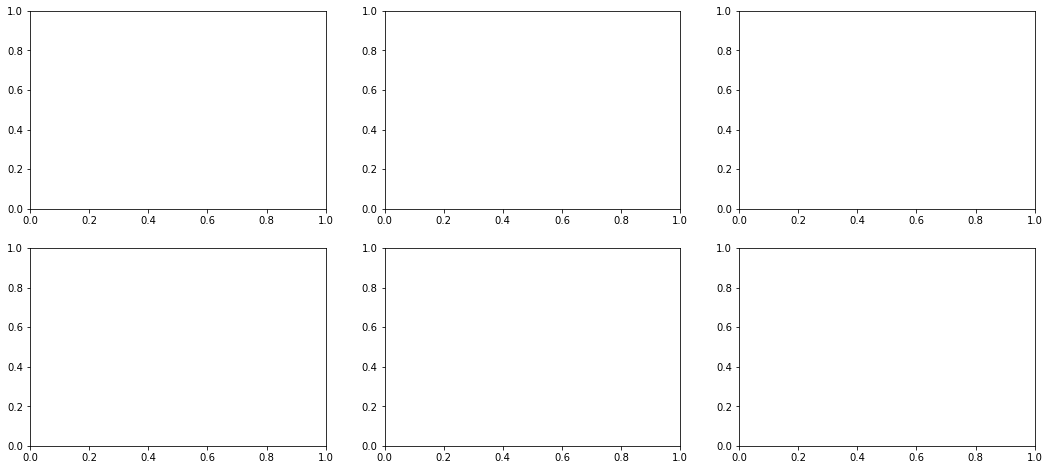

In [11]:
fig, ax_array = plt.subplots(2, 3, figsize=(18,8))

In [12]:
(ax1, ax2, ax3), (ax4, ax5, ax6) = ax_array

In [13]:
fig.suptitle('2015 US Flights - Univariate Summary', size=20)

Text(0.5, 0.98, '2015 US Flights - Univariate Summary')

In [14]:
ac = flights['AIRLINE'].value_counts()
ac.plot(kind='barh', ax=ax1, title='Airline')

In [15]:
oc = flights['ORG_AIR'].value_counts()
oc.plot(kind='bar', ax=ax2, rot=0, title='Origin City')

In [16]:
dc = flights['DEST_AIR'].value_counts().head(10)
dc.plot(kind='bar', ax=ax3, rot=0, title='Destination City')

In [17]:
status.plot(kind='bar', ax=ax4, rot=0,
 log=True, title='Flight Status')

In [18]:
flights['DIST'].plot(kind='kde', ax=ax5, xlim=(0, 3000),
 title='Distance KDE')

In [19]:
flights['ARR_DELAY'].plot(kind='hist', ax=ax6,
 title='Arrival Delay',
 range=(0,200))

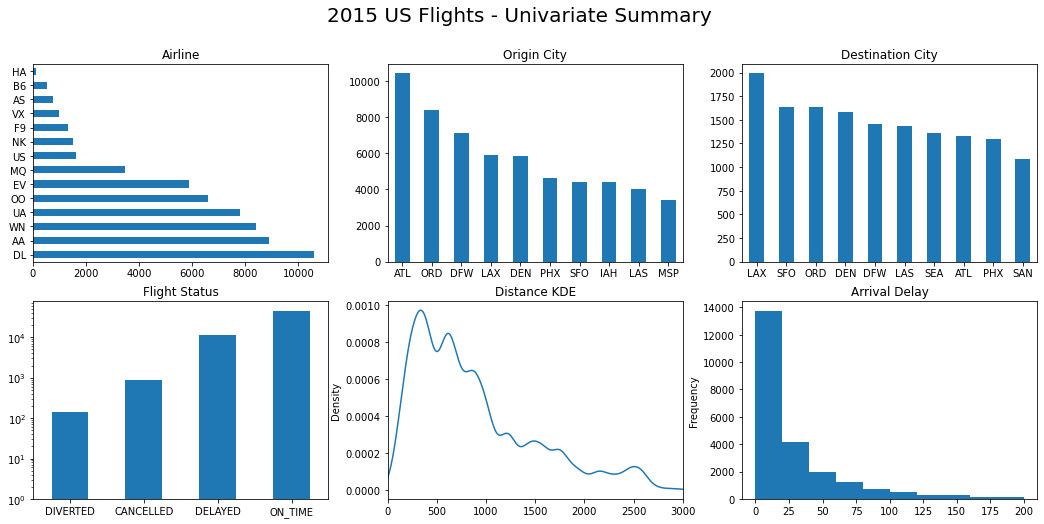

In [21]:
fig

In [22]:
hour = flights['SCHED_DEP'] // 100
minute = flights['SCHED_DEP'] % 100

In [23]:
df_date = flights[['MONTH', 'DAY']].assign(YEAR=2015,
HOUR=hour, MINUTE=minute)

In [24]:
df_date.head()

,MONTH,DAY,YEAR,HOUR,MINUTE
0,1,1,2015,16,25
1,1,1,2015,8,23
2,1,1,2015,13,5
3,1,1,2015,15,55
4,1,1,2015,17,20


In [25]:
flight_dep = pd.to_datetime(df_date)
flight_dep.head()

0   2015-01-01 16:25:00
1   2015-01-01 08:23:00
2   2015-01-01 13:05:00
3   2015-01-01 15:55:00
4   2015-01-01 17:20:00
dtype: datetime64[ns]

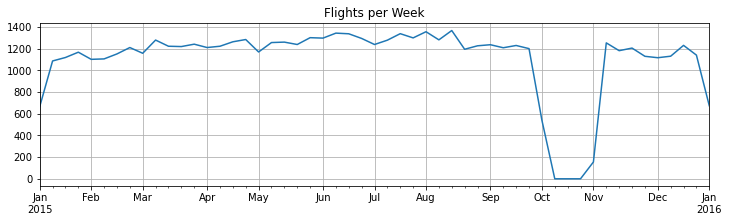

In [27]:
flights.index = flight_dep
fc = flights.resample('W').size()
fc.plot(figsize=(12,3), title='Flights per Week', grid=True)

Text(0.5, 1.0, 'Flights per Week (Interpolated Missing Data)')

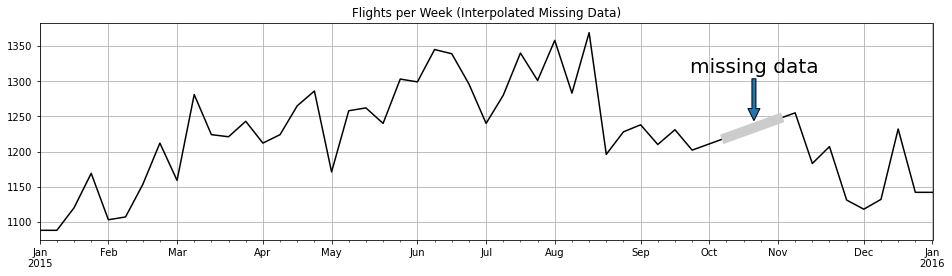

In [28]:
fc_miss = fc.where(fc > 1000)
fc_intp = fc_miss.interpolate(limit_direction='both')
ax = fc_intp.plot(color='black', figsize=(16,4))
fc_intp[fc < 500].plot(linewidth=10, grid=True,
color='.8', ax=ax)
ax.annotate(xy=(.8, .55), xytext=(.8, .77),
xycoords='axes fraction', s='missing data',
ha='center', size=20, arrowprops=dict())
ax.set_title('Flights per Week (Interpolated Missing Data)')

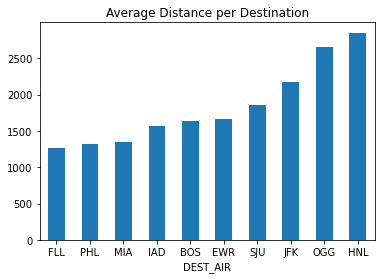

In [29]:
flights.groupby('DEST_AIR')['DIST'] \
 .agg(['mean', 'count']) \
 .query('count > 100') \
 .sort_values('mean') \
 .tail(10) \
 .plot(kind='bar', y='mean', rot=0, legend=False,
 title='Average Distance per Destination')

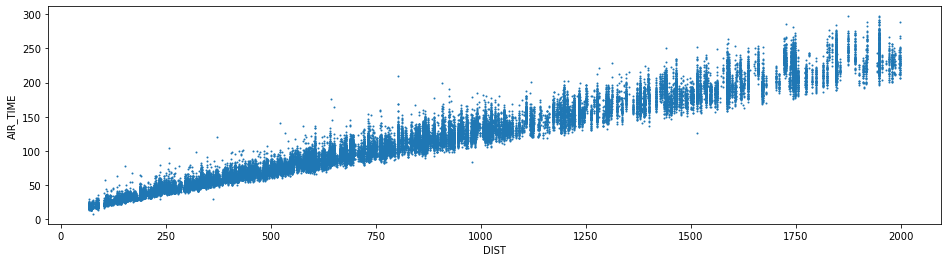

In [33]:
fs = flights.reset_index(drop=True)[['DIST', 'AIR_TIME']] \
 .query('DIST <= 2000').dropna()
fs.plot(x='DIST', y='AIR_TIME', kind='scatter',
 s=1, figsize=(16,4))

In [34]:
fs['DIST_GROUP'] = pd.cut(fs['DIST'], bins=range(0, 2001, 250))


In [35]:
fs['DIST_GROUP'].value_counts().sort_index()

(0, 250]         6529
(250, 500]      12631
(500, 750]      11506
(750, 1000]      8832
(1000, 1250]     5071
(1250, 1500]     3198
(1500, 1750]     3885
(1750, 2000]     1815
Name: DIST_GROUP, dtype: int64

In [36]:
normalize = lambda x: (x - x.mean()) / x.std()
fs['TIME_SCORE'] = fs.groupby('DIST_GROUP')['AIR_TIME'] \
 .transform(normalize)
fs.head()

,DIST,AIR_TIME,DIST_GROUP,TIME_SCORE
0,590,94.0,"(500, 750]",0.490966
1,1452,154.0,"(1250, 1500]",-1.267551
2,641,85.0,"(500, 750]",-0.296749
3,1192,126.0,"(1000, 1250]",-1.211020
4,1363,166.0,"(1250, 1500]",-0.521999


# boxplots are for outliers

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

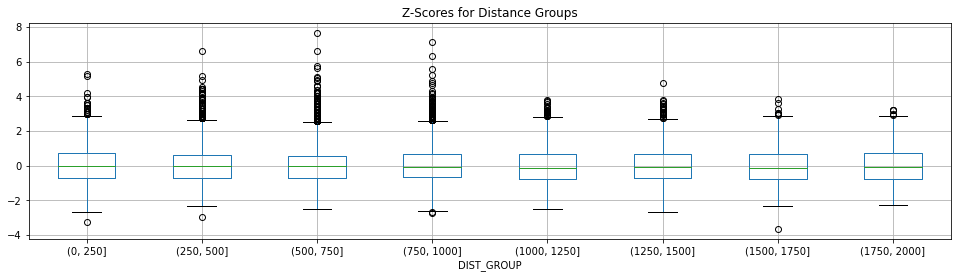

In [37]:
ax = fs.boxplot(by='DIST_GROUP', column='TIME_SCORE',
 figsize=(16,4))
ax.set_title('Z-Scores for Distance Groups')
ax.figure.suptitle('')


In [39]:
outliers = flights.iloc[fs[fs['TIME_SCORE'] > 6].index]
outliers = outliers[['AIRLINE','ORG_AIR', 'DEST_AIR',
'AIR_TIME',
 'DIST', 'ARR_DELAY', 'DIVERTED']]
outliers['PLOT_NUM'] = range(1, len(outliers) + 1)
outliers

,AIRLINE,ORG_AIR,DEST_AIR,AIR_TIME,DIST,ARR_DELAY,DIVERTED,PLOT_NUM
2015-04-08 09:40:00,DL,ATL,CVG,121.0,373,54.0,0,1
2015-05-25 16:30:00,F9,MSP,ATL,199.0,907,79.0,0,2
2015-09-10 20:00:00,UA,IAH,MCI,176.0,643,76.0,0,3
2015-12-10 19:53:00,OO,PHX,SFO,164.0,651,146.0,0,4
2015-12-26 09:15:00,NK,ORD,DFW,210.0,802,98.0,0,5


Text(0.5, 1.0, 'Flight Time vs Distance with Outliers')

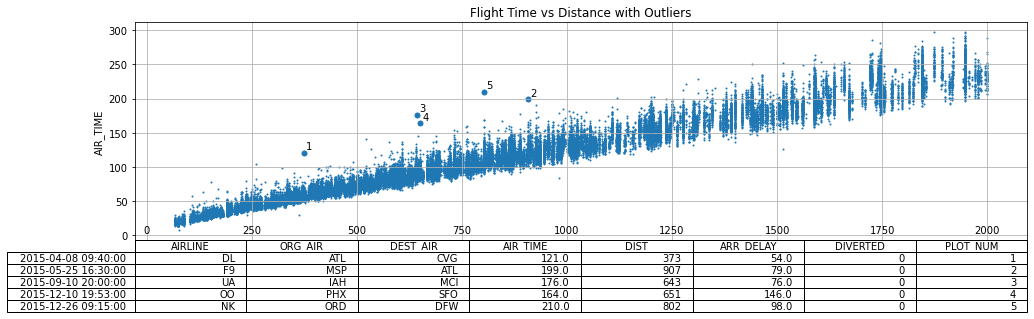

In [40]:
ax = fs.plot(x='DIST', y='AIR_TIME',
 kind='scatter', s=1,
 figsize=(16,4), table=outliers)
outliers.plot(x='DIST', y='AIR_TIME',
 kind='scatter', s=25, ax=ax, grid=True)
outs = outliers[['AIR_TIME', 'DIST', 'PLOT_NUM']]
for t, d, n in outs.itertuples(index=False):
     ax.text(d + 5, t + 5, str(n))
plt.setp(ax.get_xticklabels(), y=.1)
plt.setp(ax.get_xticklines(), visible=False)
ax.set_xlabel('')
ax.set_title('Flight Time vs Distance with Outliers')
